## Follows Create_peak_by_tissue_and_Cluster

### Initialization
Package imports and data files loading

In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
from tqdm import tqdm_notebook

from Modules.Homer import *

sys.path.append('/home/isshamie/software/NGS-Pipeline')

data_folder = '/data/isshamie/CH_tissue_TSS/'

ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'
tss_annotation = '/data/isshamie/genome/start_site_mRNA_updated_final_sort.tsv'
mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

len(tissues)

### Load in meta_sampe

meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)

long_meta_samples = pd.read_csv('Results/long_meta_samples.csv',index_col=0)


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Load peak_tissue_matrix and the annotate peaks

In [2]:
peak_tissue_matrix = pd.read_csv('Results/merged_samples/peaks_tissues.csv',index_col=0)

In [3]:
anno_peaks = pd.read_csv('Results/merged_samples/all_peaks_merged_anno.tsv',sep='\t',index_col=0)
anno_peaks.dropna(axis=1,how='all',inplace=True)
anno_peaks = anno_peaks.fillna('')
# promoter_peaks = anno_peaks[anno_peaks['Annotation'].str.contains('promoter')]
# promoter_peaks_index = promoter_peaks.index
# promoter_tissue_matrix = peak_tissue_matrix[peak_tissue_matrix.index.isin(promoter_peaks_index)]

In [5]:
print 'Number of promoter peaks: ',len(promoter_peaks)
print 'Number of Unique annotations: ' , len(promoter_peaks.groupby('Annotation'))

Number of promoter peaks:  104320
Number of Unique annotations:  64895


### Load in the unique TSS gff file
(Made from update_picr_info.ipynb)

In [4]:
tss = pd.read_csv(tss_annotation,sep='\t',index_col=0)

### Need to create an extra column for tss called 'actual_start'. 
### This is to take care of issue of a gene starting at the End when it's on the minus strand
tss['actual_start'] = tss.apply( lambda x: x['Start'] if x['Strand'] == '+' else x['End'],axis=1)

In [5]:
tss.head()

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518,176
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915,46630
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838,44597
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830,44597
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779,44568


### Adding info to peaks
### Create additional column with the nearest TSS , gene and gene_id
#### Also determine a) average distance between start sites b) scatter plot of top 2 highest, if only one, color that one but just duplicate it


In [ ]:
anno_peaks['Nearest TSS'] = ''
anno_peaks['Distance to TSS'] = np.infty
anno_peaks['isSameStrand'] = False

for ind,val in tqdm_notebook(anno_peaks.iterrows()):
    filt = tss[val['Chr'] == tss['Chr']]
    peak_start = (val['Start']+val['End'])/2
    if len(filt) != 0:
        filt2 = np.abs(filt['actual_start'] - peak_start).argmin()
        anno_peaks.set_value(ind,'Nearest TSS',tss.loc[filt2,'transcript_id'])
        
        anno_peaks.set_value(ind,'Nearest gene',tss.loc[filt2,'gene'])
        anno_peaks.set_value(ind,'Nearest gene_id',tss.loc[filt2,'gene_id'])
        
        ## Get distance to nearest gene. If on - strand, tss 'End' is the beginning
        if tss.loc[filt2,'Strand'] == '+':
            anno_peaks.set_value(ind,'Distance to TSS',peak_start - tss.loc[filt2,'actual_start'])
        elif tss.loc[filt2,'Strand'] == '-':
            anno_peaks.set_value(ind,'Distance to TSS', tss.loc[filt2,'actual_start']-peak_start)
        else:
            print 'No chr??'
        
        anno_peaks.set_value(ind,'isSameStrand',val['Strand'] == tss.loc[filt2,'Strand'])


anno_peaks.to_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t')

In [8]:
print('gene id:', len(anno_peaks.groupby('Nearest gene_id')))
print('gene:',len(anno_peaks.groupby('Nearest gene')))
print('TSS:',len(anno_peaks.groupby('Nearest TSS')))

('gene id:', 21735)
('gene:', 16692)
('TSS:', 38722)


### txn to gene map

In [ ]:
%%time
txn_to_gene = dict()
txns = set(tss['transcript_id'])
for tx in tqdm_notebook(txns):
    txn_to_gene[tx] = tss[tss['transcript_id'] == tx]['gene'][0]
    


In [15]:
for key in txn_to_gene:
    txn_to_gene[key] = txn_to_gene[key][0]

In [17]:
pickle.dump(txn_to_gene,open('Results/txn_to_gene','wb'))

### How many peaks for a specific gene. 

In [6]:
anno_peaks = pd.read_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t',index_col=0)

In [7]:
def get_peaks_within_distance(peaks,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1])]
    return filt


def get_genes_peaks(peaks,gene,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Nearest gene'] == gene) & 
                 ((peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1]))]
    return filt

def get_gene_ids_peaks(peaks,gene,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Nearest gene_id'] == gene) & 
                 ((peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1]))]
    return filt

def get_nearest_tss(peaks_gene): 
    #peaks of one gene
    peaks_gene['abs'] = np.abs(peaks_gene['Distance to TSS'])
    idx = peaks_gene['abs'].argmin()
    return idx, peaks_gene.loc[idx,'Distance to TSS']


def tss_per_gene(peaks_gene): 
    #peaks of one gene
    return len(set(peaks_gene['Nearest TSS']))


def tissues_gene_expressed(peaks_gene,peaks_tissue_matrix):
    #peaks of one gene
    curr_gene_vals = peaks_tissue_matrix[peaks_tissue_matrix.isin(peaks_gene.idnex)]
    tiss = (curr_gene_vals > 1).any(axis=1)
    tiss = tiss.columns[tiss]
    return tiss

### DataFrames with either transcript, gene, or gene_id centric df

In [ ]:
%%time
gene_list = tss['transcript_id'].unique()
txn_df = pd.DataFrame(index=gene_list,columns=['peaks','numberOfPeaks','peaksWithin_1kb_100bp',
                                                'promoterPeaks','tissues','minDistance','minDistancePeak',
                                                'maxValue','maxPeakId','maxTissues',
                                                'Chr','Start','End',
                                                'gene_id','gene','transcript'])                                              
                                               
txn_df['numberOfPeaks'] = 0
txn_df['peaks'] = ''
txn_df['minDistance'] = 0
txn_df['minDistancePeak'] = ''
txn_df['tissues'] = ''
txn_df['maxTissues'] = ''
#txn_df['Peaks'] = [[] for _ in range(txn_df.shape[0])]

for i in (anno_peaks.groupby(['Nearest TSS'])):
    curr_gene = i[0]
    txn_df.loc[curr_gene,'numberOfPeaks'] += len(i[1])
    curr = i[1]
    txn_df.set_value(curr_gene,'peaks',list(curr.index))
    
    ## Filter to only within the distance of -1kb to +100bp
    #curr = get_genes_peaks(curr,curr_gene,distance=[-1000,+100])
    curr = get_peaks_within_distance(curr,distance=[-1000,+100])
    
    txn_df.set_value(curr_gene,'peaksWithin_1kb_100bp',list(curr.index))
    
    ## Filter to only peaks with isSameStrand 
    curr = curr[curr['isSameStrand'] == True]
    txn_df.set_value(curr_gene,'promoterPeaks',list(curr.index))
    
    ## Find closest peak
    if len(curr) == 0:
        continue
    if isinstance(curr,pd.Series):
        print('is a series', curr)
        
    minPeak, minPeakValue = get_nearest_tss(curr)
    txn_df.set_value(curr_gene,'minDistance',minPeakValue)
    txn_df.set_value(curr_gene,'minDistancePeak',minPeak)

    ## Store which tissues that have a peak 
    ## Try statement b/c few peaks were not in the expression matrix for some reason
    try: 
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
        curr_tss_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(curr.index)]
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        txn_df.set_value(curr_gene,'tissues',curr_tissues)
        if 'CHO' in curr_tissues:
            txn_df.set_value(curr_gene,'is_in_cho_promoter', True)
        
        max_peak = curr_tss_peaks.max(axis=1).argmax()
        max_value = curr_tss_peaks.max(axis=1).max()
        
        
        start = curr.loc[max_peak,'Start']
        end = curr.loc[max_peak,'End']
        chrom = curr.loc[max_peak,'Chr']
        gene = curr.loc[max_peak,'Nearest gene']
        gene_id = curr.loc[max_peak,'Nearest gene_id']
        mrna = curr.loc[max_peak,'Nearest TSS']

        txn_df.set_value(curr_gene,'maxValue',max_value)
        txn_df.set_value(curr_gene,'maxPeakId',max_peak)
                    
        ## Max values and tissues
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[max_peak]>0)].values
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        txn_df.set_value(curr_gene,'maxTissues',curr_tissues)


        ## Assigning values
        txn_df.set_value(curr_gene,'transcript',mrna)
        txn_df.set_value(curr_gene,'gene',gene)
        txn_df.set_value(curr_gene,'gene_id',gene_id)
        txn_df.set_value(curr_gene,'Start',start)
        txn_df.set_value(curr_gene,'End',end)
        txn_df.set_value(curr_gene,'Chr',chrom)
        
    except KeyError :
        print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'
    
txn_df['hasGene'] = txn_df.fillna('')['promoterPeaks'].apply(lambda x: len(x) > 0)
txn_df['Number of SS'] = txn_df['promoterPeaks'].fillna('').apply(lambda x: len(x))

txn_df.to_csv('Results/txn_df.csv')
txn_df.to_pickle('Results/txn_df.p')


print('Total Number of txns: ', len(txn_df))
print('Total Number of txns with start sites: ',np.sum(txn_df['hasGene']))
print('Fraction of txns with start sites: ',1.0*np.sum(txn_df['hasGene'])/len(txn_df))

Index([u'Merged-picr_122-560705-1 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')
Index([u'Merged-picr_124-1081033-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')
Index([u'Merged-picr_4-7819598-2-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')


In [54]:

print('Total Number of txns: ', len(txn_df))
print('Total Number of txns with start sites: ',np.sum(txn_df['hasGene']))
print('Fraction of txns with start sites: ',1.0*np.sum(txn_df['hasGene'])/len(txn_df))

('Total Number of txns: ', 52382)
('Total Number of txns with start sites: ', 18431)
('Fraction of txns with start sites: ', 0.35185750830437934)


In [ ]:
txn_df

In [ ]:
%%time
gene_list = tss['gene'].unique()
gene_df = pd.DataFrame(index=gene_list,columns=['peaks','numberOfPeaks','peaksWithin_1kb_100bp',
                                                'promoterPeaks','tissues','minDistance','minDistancePeak',
                                                'maxValue','maxPeakId','maxTissues',
                                                'Chr','Start','End',
                                                'gene_id','gene','transcript'])                                              
                                               
gene_df['numberOfPeaks'] = 0
gene_df['peaks'] = ''
gene_df['minDistance'] = 0
gene_df['minDistancePeak'] = ''
gene_df['tissues'] = ''
gene_df['maxTissues'] = ''
#gene_df['Peaks'] = [[] for _ in range(gene_df.shape[0])]
gene_df['is_in_cho_promoter'] = False

for i in tqdm_notebook(anno_peaks.groupby(['Nearest gene'])):
    curr_gene = i[0]
    
    gene_df.loc[curr_gene,'numberOfPeaks'] += len(i[1])
    curr = i[1]
    
    ## All peaks that are nearest to gene
    gene_df.set_value(curr_gene,'peaks',list(curr.index))
    
    ## Filter to only within the distance of -1kb to +100bp
    curr = get_peaks_within_distance(curr,distance=[-1000,+100])
    gene_df.set_value(curr_gene,'peaksWithin_1kb_100bp',list(curr.index))
    
    ## Filter to only peaks with isSameStrand 
    curr = curr[curr['isSameStrand'] == True]
    gene_df.set_value(curr_gene,'promoterPeaks',list(curr.index))
    
    ## Find closest peak
    if len(curr) == 0:
        continue
    if isinstance(curr,pd.Series):
        print('is a series', curr)
    
    ## Closest distance to the annotated peak
    minPeak, minPeakValue = get_nearest_tss(curr)
    gene_df.set_value(curr_gene,'minDistance',minPeakValue)
    gene_df.set_value(curr_gene,'minDistancePeak',minPeak)

    ## Store which tissues that have a peak 
    ## Try statement b/c few peaks were not in the expression matrix for some reason
    try: 
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
        curr_tss_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(curr.index)]
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        gene_df.set_value(curr_gene,'tissues',curr_tissues)
        if 'CHO' in curr_tissues:
            gene_df.set_value(curr_gene,'is_in_cho_promoter', True)
        
        ## Strongest peak and tissues associated
#         if len(curr) > 1:
#             max_peak = curr.max(axis=1).argmax()
#             max_value = curr.max(axis=1).max()
#             start = curr.loc[max_peak,'Start']
#             end = curr.loc[max_peak,'End']
#             chrom = curr.loc[max_peak,'Chr']
#             gene = curr.loc[max_peak,'Nearest gene']
#             gene_id = curr.loc[max_peak,'Nearest gene_id']
#             mrna = curr.loc[max_peak,'Nearest TSS']

#         else:
#             max_peak = curr.index[0]
#             max_value = curr.max().max()
#             start = curr['Start']
#             end = curr['End']
#             chrom = curr['Chr']
#             gene_id = curr['Nearest gene_id']
#             mrna = curr['Nearest TSS']
#             gene = curr['Nearest gene']


        start = curr.loc[max_peak,'Start']
        end = curr.loc[max_peak,'End']
        chrom = curr.loc[max_peak,'Chr']
        gene = curr.loc[max_peak,'Nearest gene']
        gene_id = curr.loc[max_peak,'Nearest gene_id']
        mrna = curr.loc[max_peak,'Nearest TSS']
        
        ## Assigning additional values
        gene_df.set_value(curr_gene,'transcript',mrna)
        gene_df.set_value(curr_gene,'gene',gene)
        gene_df.set_value(curr_gene,'gene_id',gene_id)
        gene_df.set_value(curr_gene,'Start',start)
        gene_df.set_value(curr_gene,'End',end)
        gene_df.set_value(curr_gene,'Chr',chrom)
        gene_df.set_value(curr_gene,'maxValue',max_value)
        gene_df.set_value(curr_gene,'maxPeakId',max_peak)

        ## Max values and tissues
        max_peak = curr_tss_peaks.max(axis=1).argmax()
        max_value = curr_tss_peaks.max(axis=1).max()
        
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[max_peak]>0)].values
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        gene_df.set_value(curr_gene,'maxTissues',curr_tissues)



        
    except KeyError :
        print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'
    
gene_df['hasGene'] = gene_df.fillna('')['promoterPeaks'].apply(lambda x: len(x) > 0)
gene_df['Number of SS'] = gene_df['promoterPeaks'].fillna('').apply(lambda x: len(x))

In [ ]:
gene_df.to_csv("Results/gene_df.tsv",sep='\t')

gene_df.to_pickle('Results/gene_df.p')


In [ ]:
print('Total Number of genes: ', len(gene_df))
print('Total Number of genes with start sites: ',np.sum(gene_df['hasGene']))
print('Fraction of start sites: ',1.0*np.sum(gene_df['hasGene'])/len(gene_df))

### Same as gene, but gene_id

In [ ]:
%%time
gene_list = tss['gene_id'].unique()
gene_id_df = pd.DataFrame(index=gene_list,columns=['peaks','numberOfPeaks','peaksWithin_1kb_100bp',
                                                'promoterPeaks','tissues','minDistance','minDistancePeak',
                                                'maxValue','maxPeakId','maxTissues',
                                                'Chr','Start','End',
                                                'gene_id','gene','transcript'])                                              
                                               
gene_id_df['numberOfPeaks'] = 0
gene_id_df['peaks'] = ''
gene_id_df['minDistance'] = 0
gene_id_df['minDistancePeak'] = ''
gene_id_df['tissues'] = ''
gene_id_df['maxTissues'] = ''
#gene_id_df['Peaks'] = [[] for _ in range(gene_id_df.shape[0])]

for i in tqdm_notebook(anno_peaks.groupby(['Nearest gene_id'])):
    curr_gene = i[0]
    gene_id_df.loc[curr_gene,'numberOfPeaks'] += len(i[1])
    curr = i[1]
    gene_id_df.set_value(curr_gene,'peaks',list(curr.index))
    
    ## Filter to only within the distance of -1kb to +100bp
    curr = get_peaks_within_distance(curr,distance=[-1000,+100])
    
    gene_id_df.set_value(curr_gene,'peaksWithin_1kb_100bp',list(curr.index))
    
    ## Filter to only peaks with isSameStrand 
    curr = curr[curr['isSameStrand'] == True]
    gene_id_df.set_value(curr_gene,'promoterPeaks',list(curr.index))
    
    ## Find closest peak
    if len(curr) == 0:
        continue
    if isinstance(curr,pd.Series):
        print('is a series', curr)  
    minPeak, minPeakValue = get_nearest_tss(curr)
    gene_id_df.set_value(curr_gene,'minDistance',minPeakValue)
    gene_id_df.set_value(curr_gene,'minDistancePeak',minPeak)

    ## Store which tissues that have a peak 
    ## Try statement b/c few peaks were not in the expression matrix for some reason
    try: 
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
        curr_tss_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(curr.index)]
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        gene_id_df.set_value(curr_gene,'tissues',curr_tissues)
        if 'CHO' in curr_tissues:
            gene_id_df.set_value(curr_gene,'is_in_cho_promoter', True)
     
        
        start = curr.loc[max_peak,'Start']
        end = curr.loc[max_peak,'End']
        chrom = curr.loc[max_peak,'Chr']
        gene = curr.loc[max_peak,'Nearest gene']
        gene_id = curr.loc[max_peak,'Nearest gene_id']
        mrna = curr.loc[max_peak,'Nearest TSS']
        ## Assigning values
        gene_id_df.set_value(curr_gene,'transcript',mrna)
        gene_id_df.set_value(curr_gene,'gene',gene)
        gene_id_df.set_value(curr_gene,'gene_id',gene_id)
        gene_id_df.set_value(curr_gene,'Start',start)
        gene_id_df.set_value(curr_gene,'End',end)
        gene_id_df.set_value(curr_gene,'Chr',chrom)
        
        
        gene_id_df.set_value(curr_gene,'maxValue',max_value)
        gene_id_df.set_value(curr_gene,'maxPeakId',max_peak)

        ## Max values and tissues
        max_peak = curr_tss_peaks.max(axis=1).argmax()
        max_value = curr_tss_peaks.max(axis=1).max()     
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[max_peak]>0)].values
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        gene_id_df.set_value(curr_gene,'maxTissues',curr_tissues)



    except KeyError :
        print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'
    
gene_id_df['hasGene'] = gene_id_df.fillna('')['promoterPeaks'].apply(lambda x: len(x) > 0)
gene_id_df['Number of SS'] = gene_id_df['promoterPeaks'].fillna('').apply(lambda x: len(x))

gene_id_df.to_pickle('Results/gene_id_df.p')


print('Total Number of gene_ids: ', len(gene_id_df))
print('Total Number of gene_ids with start sites: ',np.sum(gene_id_df['hasGene']))
print('Fraction of gene_ids with start sites: ',1.0*np.sum(gene_id_df['hasGene'])/len(gene_id_df))

### How many peaks for a specific gene. 
### How many tissues 
### What was the strongest peak
### Distance between peaks (if we separate the transcripts out)
### How many start sites


('Number of genes with greater than 10 peaks:', 18)


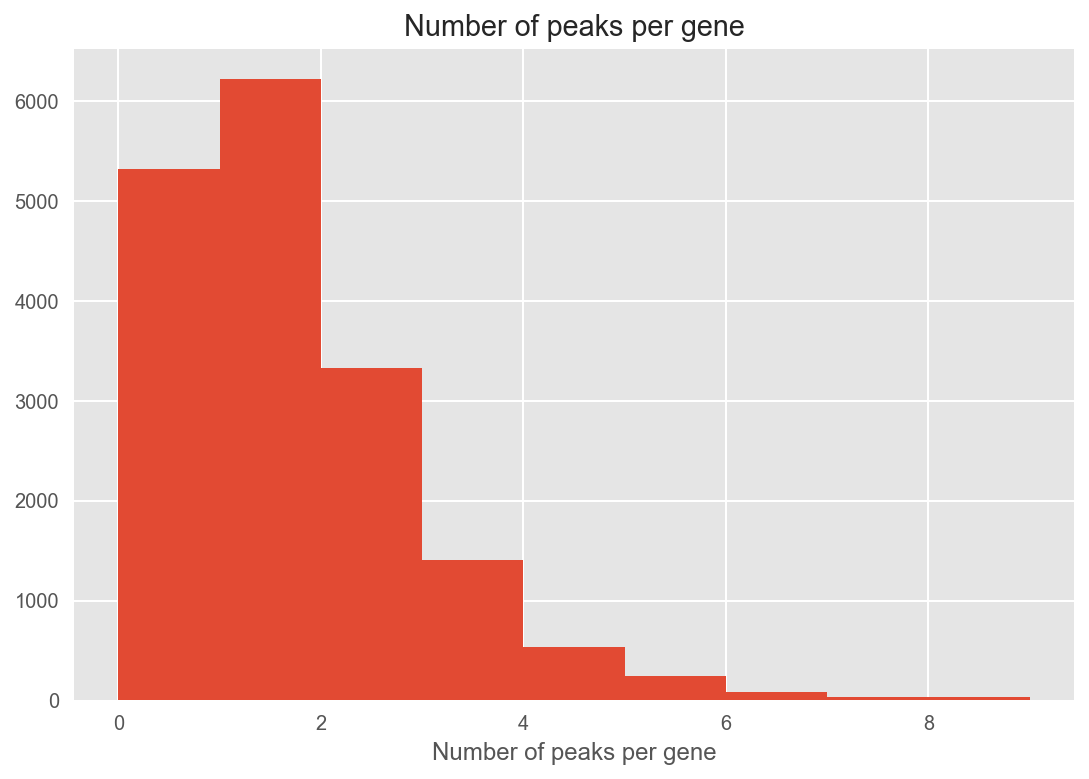

In [17]:
#sns.distplot(start_sites_gff['Experimental'],kde=False,norm_hist=False)

f = plt.figure();
ax = f.add_subplot(1,1,1);
#ax.hist(gene_df['Number of SS']);
gene_df_small = gene_df[gene_df['Number of SS']<10]
ax.hist(gene_df_small['Number of SS'],bins=max(gene_df_small['Number of SS']))
ax.set_xlabel('Number of peaks per gene')
#ax.set_xticks(range(0,max(gene_df['Number of SS'])+1,2))
print('Number of genes with greater than 10 peaks:',np.sum(gene_df['Number of SS']>10))
plt.title('Number of peaks per gene')
plt.savefig('Results/Figures/Number_of_peaks_per_gene.png')

('Number of genes with greater than 10 peaks:', 3)


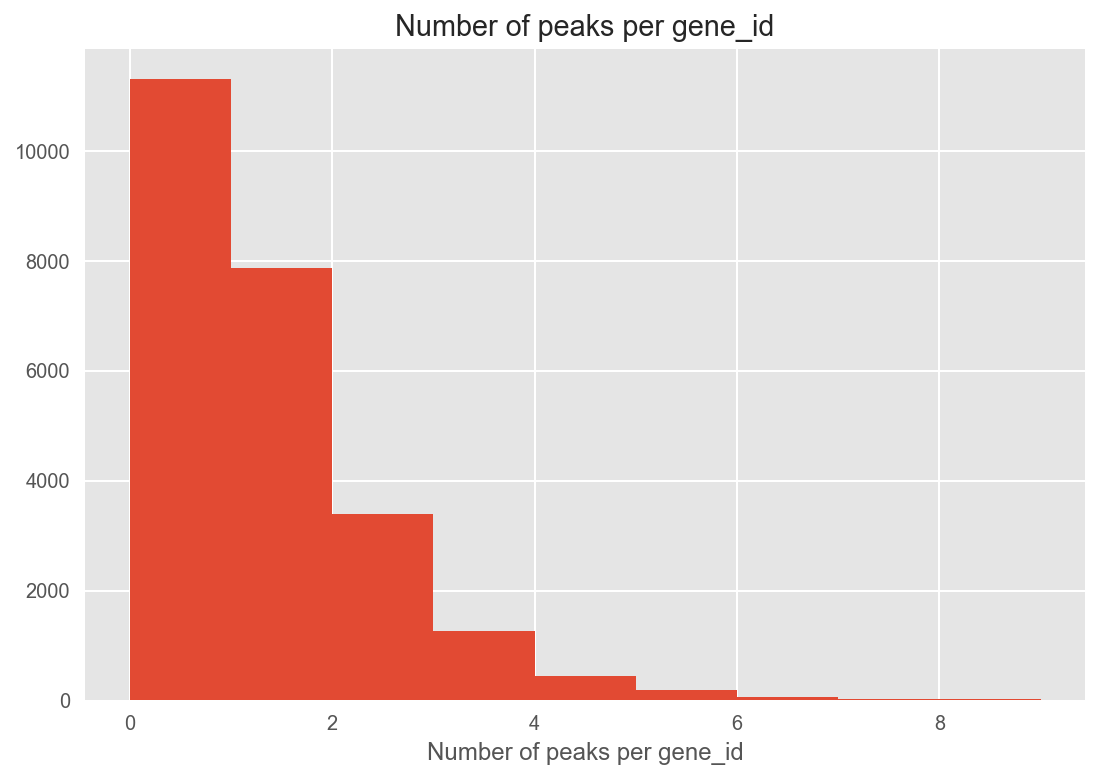

In [18]:
#sns.distplot(start_sites_gff['Experimental'],kde=False,norm_hist=False)

f = plt.figure();
ax = f.add_subplot(1,1,1);
#ax.hist(gene_id_df['Number of SS']);
gene_id_df_small = gene_id_df[gene_id_df['Number of SS']<10]
ax.hist(gene_id_df_small['Number of SS'],bins=max(gene_id_df_small['Number of SS']))
ax.set_xlabel('Number of peaks per gene_id')
#ax.set_xticks(range(0,max(gene_id_df['Number of SS'])+1,2))
print('Number of genes with greater than 10 peaks:',np.sum(gene_id_df['Number of SS']>10))
plt.title('Number of peaks per gene_id')
plt.savefig('Results/Figures/Number_of_peaks_per_gene_id.png')

('Number of genes with greater than 10 peaks:', 0)


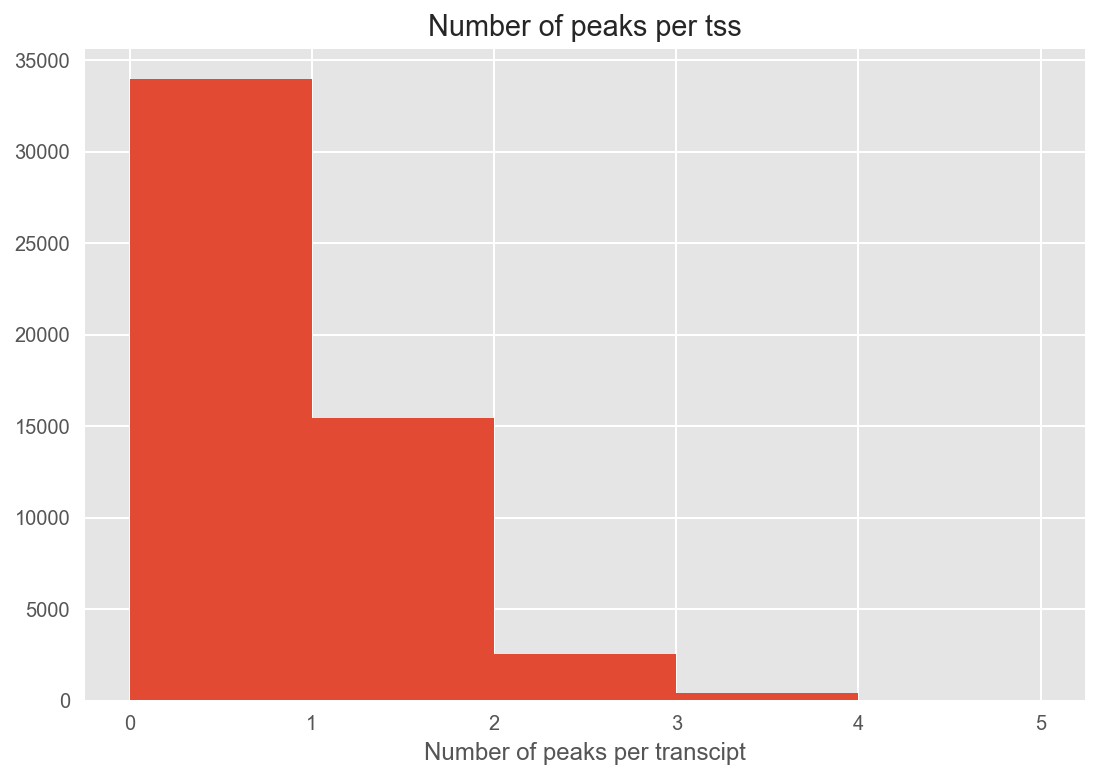

In [20]:
#sns.distplot(start_sites_gff['Experimental'],kde=False,norm_hist=False)

f = plt.figure();
ax = f.add_subplot(1,1,1);
#ax.hist(txn_df['Number of SS']);
txn_df_small = txn_df[txn_df['Number of SS']<10]
ax.hist(txn_df_small['Number of SS'],bins=max(txn_df_small['Number of SS']))
ax.set_xlabel('Number of peaks per transcipt')
#ax.set_xticks(range(0,max(txn_df['Number of SS'])+1,2))
print('Number of genes with greater than 10 peaks:',np.sum(txn_df['Number of SS']>10))

plt.title('Number of peaks per tss')
plt.savefig('Results/Figures/Number_of_peaks_per_txn.png')

In [46]:

tss

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518,176
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915,46630
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838,44597
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830,44597
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779,44568
ID=asmbl_10;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_10;cs=1,picr_0,7821,44513,-,asmbl_10,gene_2,gene_2,RRP7A,asmbl_10,1,36692,44513
ID=asmbl_11;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_11;cs=2,picr_0,18149,43772,+,asmbl_11,gene_1_4,gene_1_4,SERHL,asmbl_11,2,25623,18149
ID=asmbl_12;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_12;cs=2,picr_0,20787,42039,+,asmbl_12,gene_1_4,gene_1_4,SERHL,asmbl_12,2,21252,20787
ID=asmbl_14;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_14;cs=2,picr_0,20942,38694,+,asmbl_14,gene_1_4,gene_1_4,SERHL,asmbl_14,2,17752,20942
ID=asmbl_15;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_15;cs=4,picr_0,22504,23694,+,asmbl_15,gene_1_4,gene_1_4,SERHL,asmbl_15,4,1190,22504


In [48]:
txn_df

,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
asmbl_2,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_4,"[Merged-picr_0-50487-1, Merged-picr_0-49682-1,...",3,[],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_7,[Merged-picr_0-44634-10],1,[Merged-picr_0-44634-10],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_8,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_9,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_10,"[Merged-picr_0-44492-5, Merged-picr_0-44249-1,...",4,[Merged-picr_0-44492-5],[Merged-picr_0-44492-5],"[Brain_GRO, Brain_mSTART, MiscOrgans_mSTART, S...",19,Merged-picr_0-44492-5,91.1,Merged-picr_0-44492-5,"[Brain_GRO, Brain_mSTART, MiscOrgans_mSTART, S...",picr_0,44414,44574,gene_2,RRP7A,asmbl_10,True,1
asmbl_11,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_12,[Merged-picr_0-20807-11],1,[Merged-picr_0-20807-11],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_14,[Merged-picr_0-20958-19],1,[Merged-picr_0-20958-19],[Merged-picr_0-20958-19],"[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",31,Merged-picr_0-20958-19,1089.35,Merged-picr_0-20958-19,"[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",picr_0,20879,21067,gene_1_4,SERHL,asmbl_14,True,1
asmbl_15,[Merged-picr_0-27692-1],1,[],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0


In [82]:
txn_hasTSS = txn_df[txn_df['hasGene']]
txn_hasTSS = txn_hasTSS[~(txn_hasTSS.isnull().any(axis=1))]

## Putting into bed format
tss_peakCenter_bed = pd.DataFrame()
for ind,val in txn_hasTSS.iterrows():
    cs = tss[tss['transcript_id'] == ind]['cs'].values[0]
    title = '%s;%s;%s;%s;cs=%d' % (val['gene'],val['gene_id'],ind,','.join(val['tissues']),cs)

    
    strand = tss[tss['transcript_id'] == ind]['Strand'].values[0]
    
    tss_peakCenter_bed = tss_peakCenter_bed.append({'chrom':val['Chr'], 
                                'chromStart': val['Start'],
                                'chromEnd':val['End'],
                                'name':title,
                                'score': val['maxValue'],
                                'strand':strand},ignore_index=True)

    
tss_peakCenter_bed = tss_peakCenter_bed[['chrom','chromStart','chromEnd','name','score','strand']]
tss_peakCenter_bed['chromStart'] = tss_peakCenter_bed['chromStart'].astype(int)
tss_peakCenter_bed['chromEnd'] = tss_peakCenter_bed['chromEnd'].astype(int)

In [83]:
tss_peakCenter_bed

,chrom,chromStart,chromEnd,name,score,strand
0,picr_0,44414,44574,"RRP7A;gene_2;asmbl_10;Brain_GRO,Brain_mSTART,M...",91.099998,-
1,picr_0,20879,21067,"SERHL;gene_1_4;asmbl_14;BloondnegSpleen_GRO,BM...",1089.349976,+
2,picr_0,66072,66222,POLDIP3;gene_3_1;asmbl_18;BMDM1hKLA1_GRO;cs=1,31.799999,-
3,picr_0,78182,78421,"POLDIP3;gene_3_1;asmbl_19;BloondnegSpleen_GRO,...",367.649994,-
4,picr_0,92486,92760,"CYB5R3;gene_3_2;asmbl_20;BMDM1hKLA1_GRO,BMDMwt...",91.400002,-
5,picr_0,186158,186419,"A4GALT;gene_4_3;asmbl_24;BloondnegSpleen_GRO,B...",95.199997,-
6,picr_0,185654,185806,"A4GALT;gene_4_3;asmbl_30;BloondnegSpleen_GRO,B...",345.149994,-
7,picr_0,298121,298309,"ARFGAP3;gene_5_1;asmbl_31;BloondnegSpleen_GRO,...",3116.100098,-
8,picr_0,399518,399668,PACSIN2;gene_6;asmbl_39;BMDM1hKLA1_GRO;cs=1,33.099998,-
9,picr_0,398718,398918,"PACSIN2;gene_6;asmbl_43;BloondnegSpleen_GRO,BM...",12232.599609,-


In [84]:
f_save = 'Results/tss_final/tss_peakCenter.bed'
tss_peakCenter_bed.to_csv(f_save + '.bed',sep='\t',header=None,index=None)

## Clustering

In [101]:
gene_df = pickle.load(open("Results/gene_df.p",'rb'))

In [102]:
def gene_df_to_TSS_expression(gene_df,peak_tissue_matrix):
    ''' Create geneXpeakValue matrix where rows are genes and cols are tissues.
    For each gene, take all the peaks that match that, and for each tissue, take its max expression for each tissue
    '''
    gene_tissue_matrix = pd.DataFrame(index=gene_df.index,columns=peak_tissue_matrix.columns,dtype='float32').fillna(0)

    for ind,val in tqdm_notebook(gene_df.iterrows()):
        if type(val['promoterPeaks']) == list:#type(val['sameSt'~np.isnan(val['promoterPeaks']):
            curr_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(val['promoterPeaks'])]
            gene_tissue_matrix.loc[ind] = curr_peaks.max()
    gene_tissue_matrix.fillna(0,inplace=True)
    return gene_tissue_matrix

In [103]:
gene_tissue_matrix = gene_df_to_TSS_expression(gene_df,peak_tissue_matrix)

In [104]:
gene_tissue_matrix.to_csv('Results/merged_samples/genes_tissues.csv')
gene_tissue_matrix.fillna(0,inplace=True)

In [105]:
## Remove genes with no expression in any tissues
short_gene_tissue = gene_tissue_matrix[~(np.sum(gene_tissue_matrix == 0,axis=1) == gene_tissue_matrix.shape[1])]
print(len(gene_tissue_matrix))
print(len(short_gene_tissue))


17246
11919


In [106]:
gene_tissue_matrix.head()

,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak,BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak,BMDMwt/GRO/f04_peaks/merge_bg_2.peak,Brain/GRO/f04_peaks/merge_bg_2.peak,Brain/mSTART/f04_peaks/merge_bg_2.peak,FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak,Heart/mSTART/f04_peaks/merge_bg_2.peak,Kidney/GRO/f04_peaks/merge_bg_2.peak,Kidney/mSTART/f04_peaks/merge_bg_2.peak,Liver/GRO/f04_peaks/merge_bg_2.peak,Liver/mSTART/f04_peaks/merge_bg_2.peak,Lung/GRO/f04_peaks/merge_bg_2.peak,Lung/mSTART/f04_peaks/merge_bg_2.peak,MiscOrgans/mSTART/f04_peaks/merge_bg_2.peak,Muscle/mSTART/f04_peaks/merge_bg_2.peak,Pancreas/mSTART/f04_peaks/merge_bg_2.peak,Spleen/mSTART/f04_peaks/merge_bg_2.peak,CHO/GRO/f04_peaks/merge_bg_2.peak,CHO/mSTART/f04_peaks/merge_bg_2.peak
SERHL,188.199997,13.300000,90.199997,333.500000,501.799988,1089.349976,777.750000,453.299988,18793.900391,374.600006,337.950012,294.100006,282.199982,697.300049,593.450012,529.299988,201.000000,971.449951,819.599976
RRP7A,0.000000,0.000000,0.000000,25.299999,27.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.650000,0.000000,0.000000,91.099998,0.000000,34.299999
POLDIP3,135.199997,31.799999,97.699997,122.599998,367.649994,148.149994,79.500000,84.199997,0.000000,85.099998,0.000000,132.199997,0.000000,174.800003,105.100006,0.000000,135.500000,317.799988,324.100006
CYB5R3,0.000000,91.400002,45.099998,0.000000,0.000000,14.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.850000
A4GALT,30.799999,324.600006,257.299988,59.900002,0.000000,136.250000,345.149994,85.300003,48.950001,0.000000,0.000000,95.199997,0.000000,98.949997,291.750000,0.000000,37.400002,0.000000,0.000000


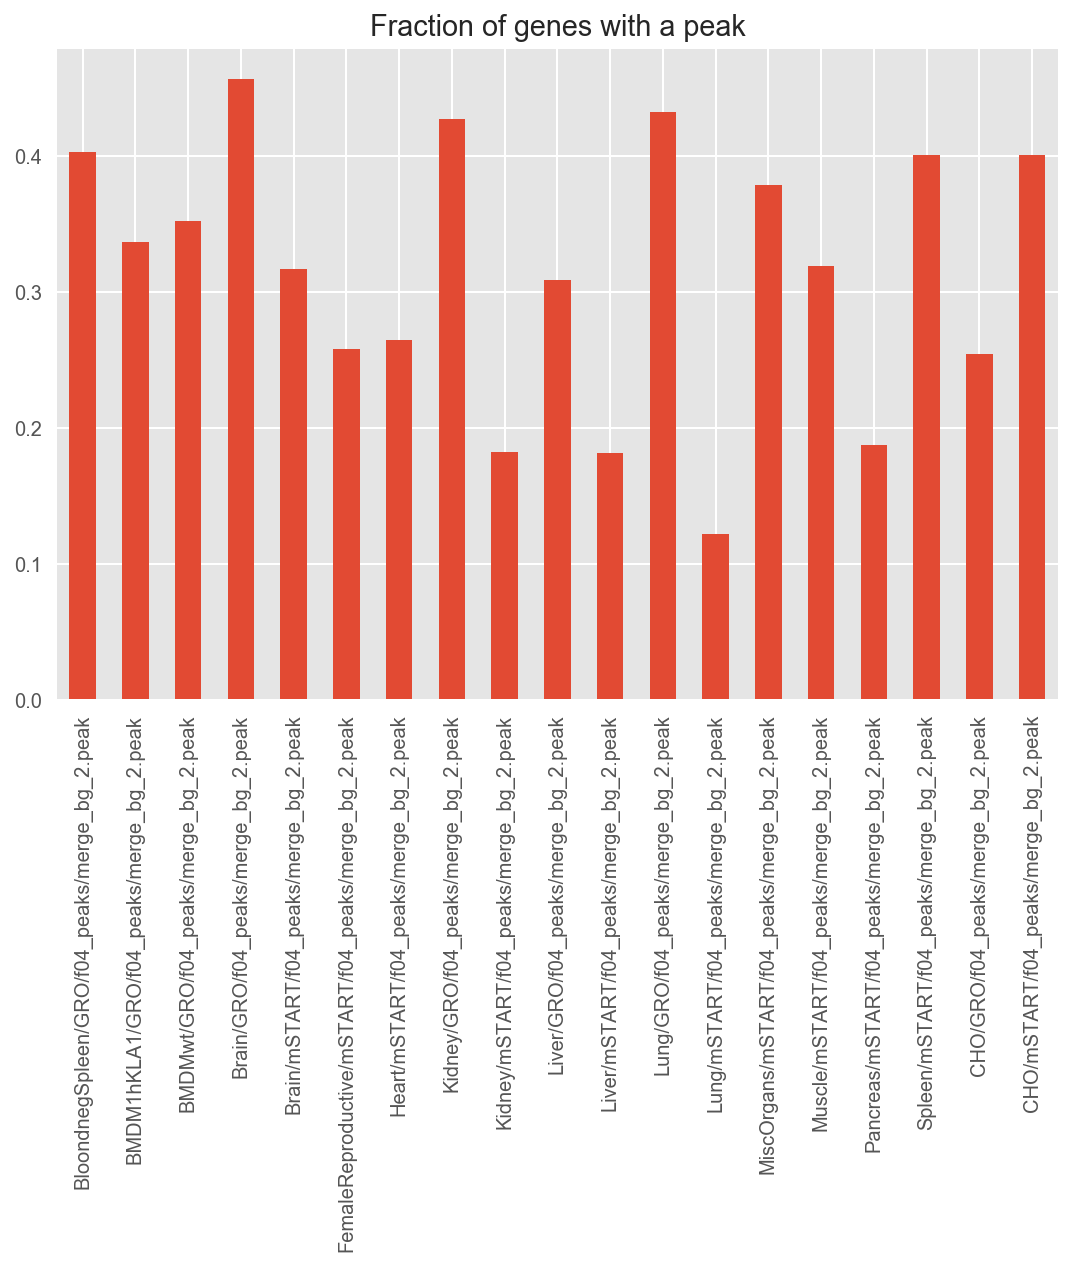

In [107]:
f = plt.figure()
ax = (np.sum((short_gene_tissue>0))/gene_df.shape[0]).plot.bar()
ax.set_title('Fraction of genes with a peak')

### Binary

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


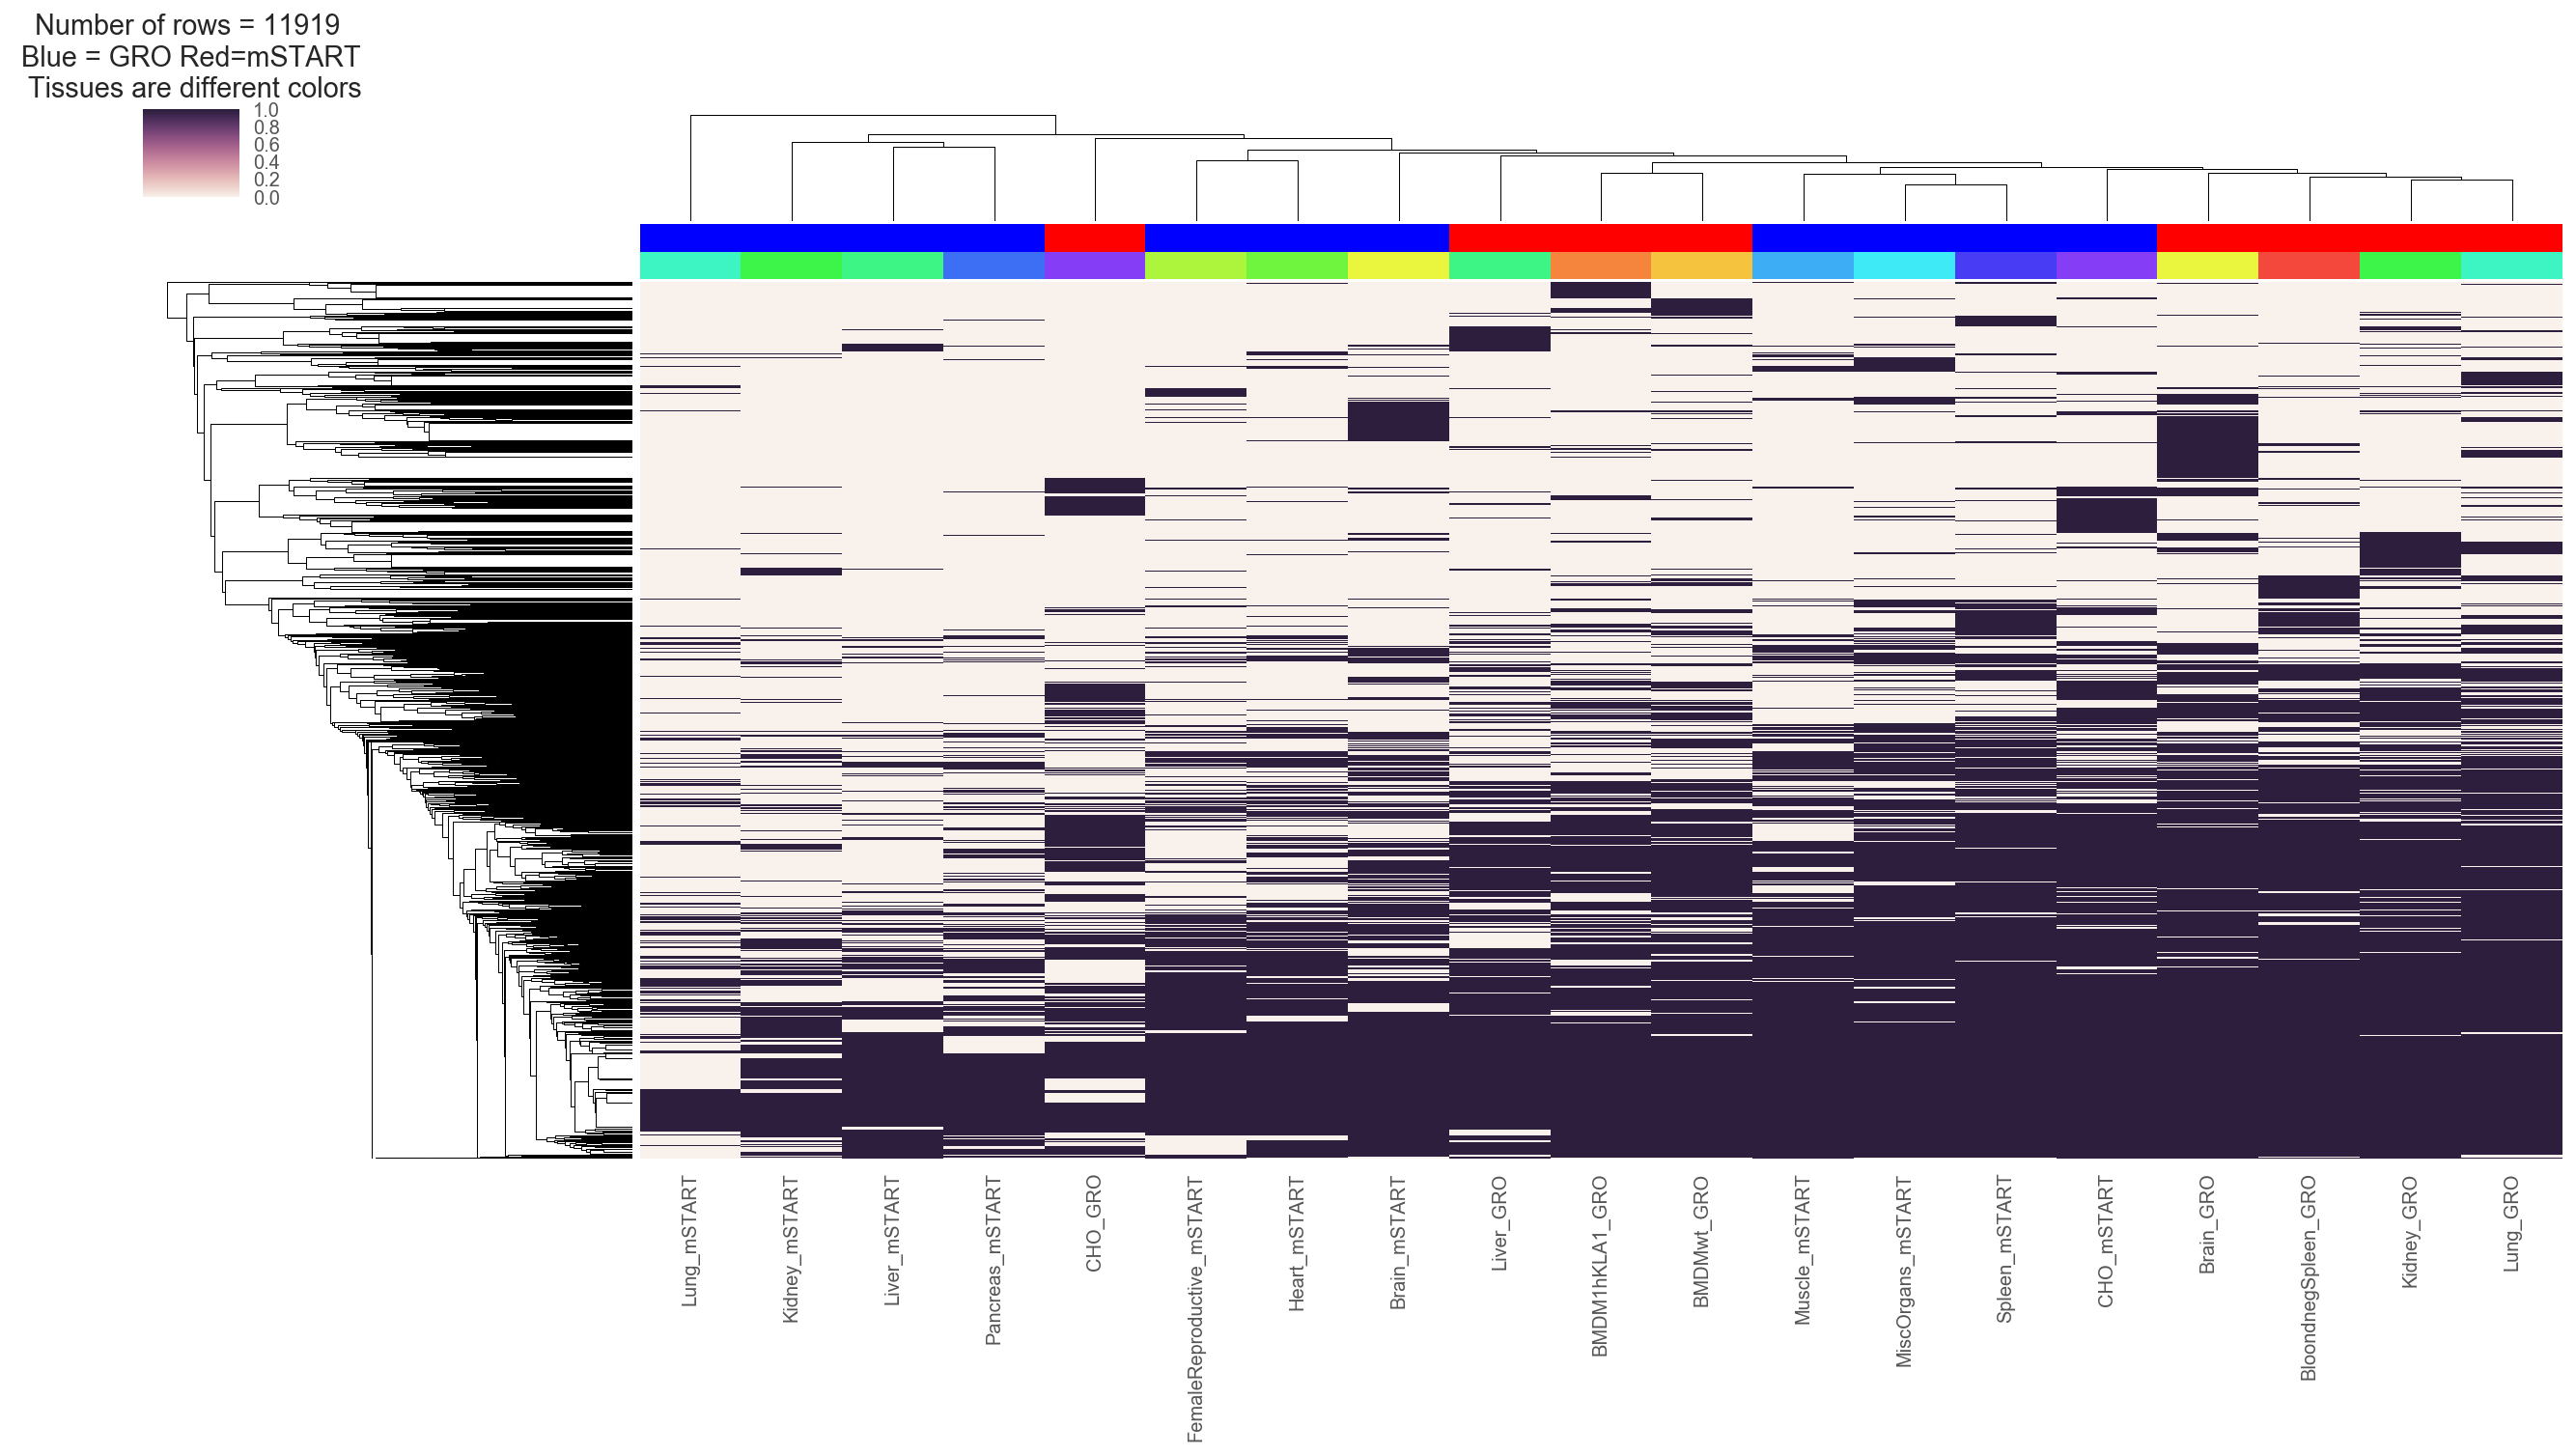

In [45]:
n_tis = len(set(meta_samples['Tissue']))


lut = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].map(lut2)

g = sns.clustermap((short_gene_tissue>0),col_cluster=True,figsize=(20,10),metric='jaccard',
                   yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=meta_samples.loc[short_gene_tissue.columns.values,'Short'])

# g = sns.clustermap(short_gene_tissue,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
#                    ,yticklabels=False)

title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(short_gene_tissue)
plt.title(title)
g.savefig('Results/Figures/binary_promoter_gene_cluster.png',bbox_inches='tight')

### log2(val+1)

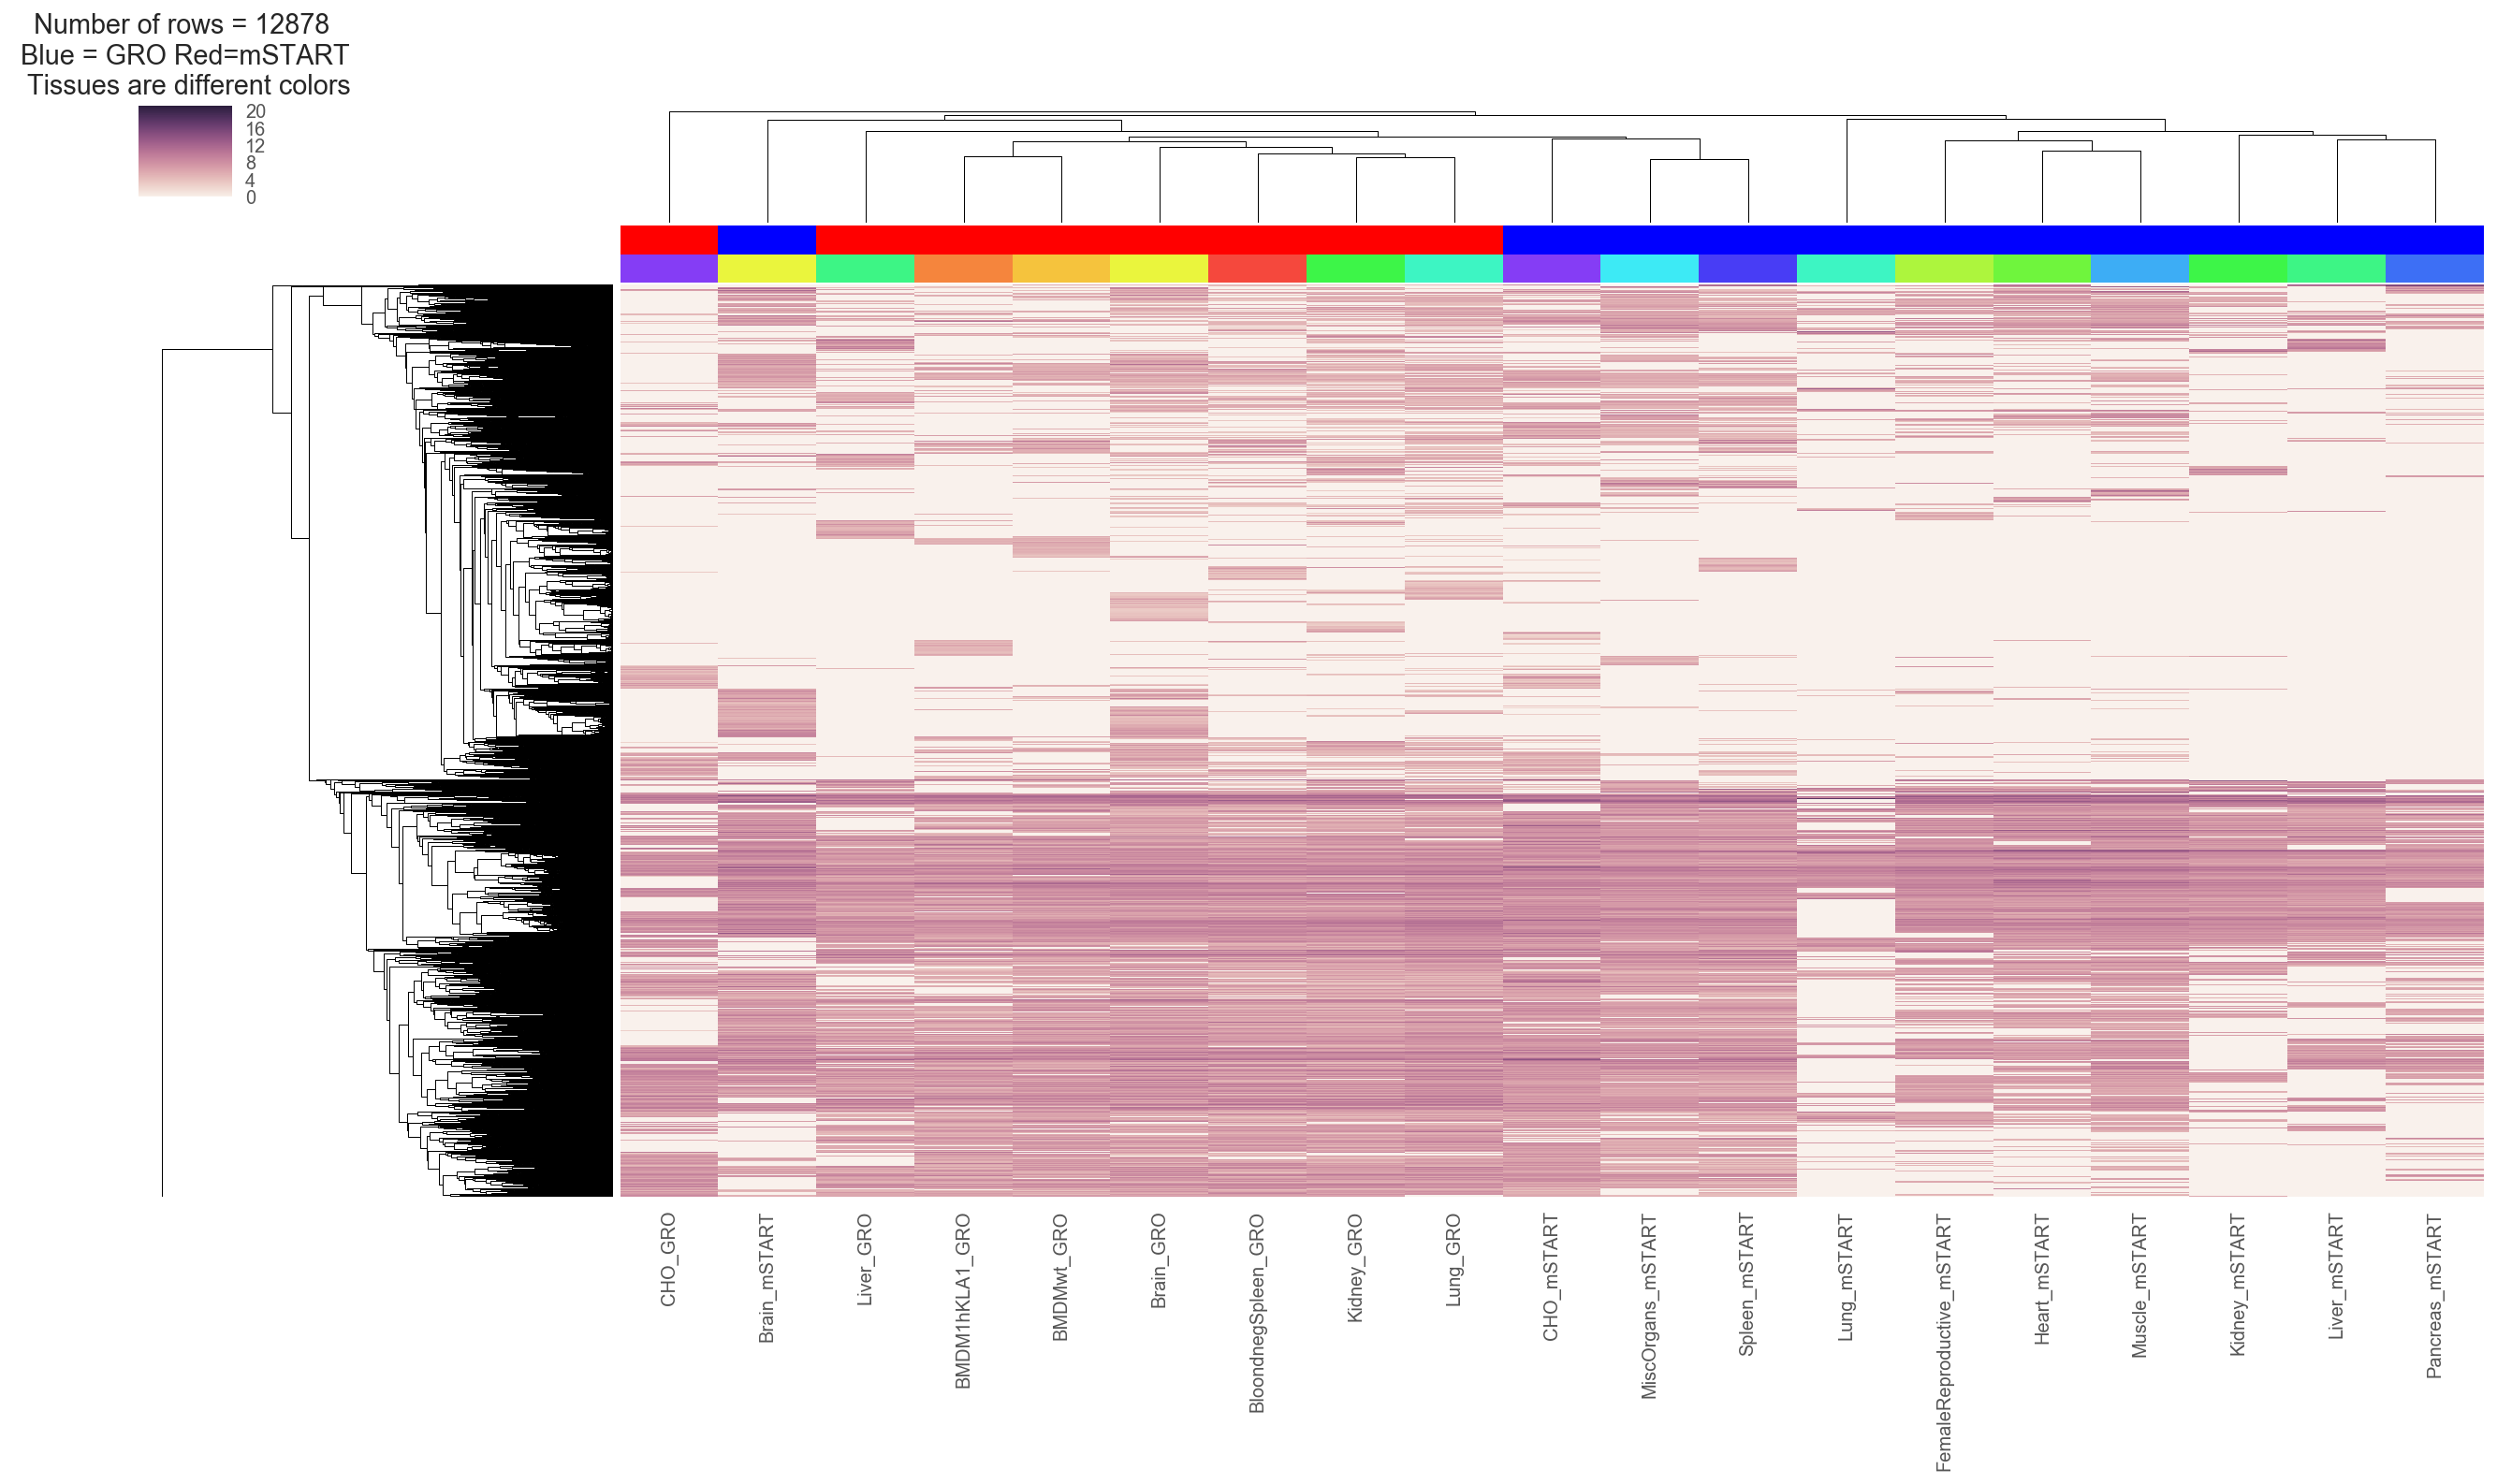

In [53]:
n_tis = len(set(meta_samples['Tissue']))

lut = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].map(lut2)

g = sns.clustermap(np.log2(short_gene_tissue+1),
                   col_cluster=True,
                   figsize=(20,10),
                   yticklabels=False,
                   col_colors=[col_colors,col_colors2],
                   xticklabels=meta_samples.loc[short_gene_tissue.columns.values,'Short'])


title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(short_gene_tissue)
plt.title(title)
g.savefig('Results/Figures/promoter_gene_cluster.png',bbox_inches='tight')